# The effect of the HQH projection on the initial conditions
When we run the constrained UOT algorithm with Dougals-Rachford algortihm, we project our variables into the space of variables where the interpolation constraint $I(U)=V$ and the affine constraint $h(V) = F$ is satsfied. However, if the constrants are satisfied in the first placee, then the projection should have no effect on the variable. We will verify that this is the case in the context of the "Wall Do Not Touch Mass" experiment in [this notebook]([FAILS]walls_do_not_touch_mass.ipynb).


In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic, precomputeProjInterp, precomputeHQH, projinterp_constraint_
from proximal.grids import speed_and_growth, CSvar
import ipywidgets as widgets
from ipywidgets import interact
from collections import defaultdict
from PIL import Image

# Plotting functions

In [2]:
def plot_lists(list):
    name = ["Energy", "Violation of Continuty", "Violation of Constraint", "Violation of Interp"]
    # Plot a list of arrays
    fig, axs = plt.subplots(1, len(list), figsize=(15, 5))
    for i in range(len(list)):
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel('Value')
        axs[i].set_title('Plot of ' + name[i])
        axs[i].plot(list[i])
    plt.show()

def plot_log(log):
    # Plot 'pre_lambda', 'lambda', and 'first_order_condition' using subplots with different colors
    fig, axs = plt.subplots(4, 1, figsize=(10, 18))
    
    axs[0].plot(log['U_prime_interp'], label='U_prime_interp', color='blue')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Value')
    axs[0].set_title('Plot of U_prime_interp')
    axs[0].legend()

    # Plot 'pre_lambda'
    axs[1].plot(log['pre_lambda'], label='pre_lambda', color='blue')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Plot of pre_lambda')
    axs[1].legend()
    
    # Plot 'lambda'
    axs[2].semilogy(log['lambda'], label='lambda', color='green')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Value')
    axs[2].set_title('Plot of lambda')
    axs[2].legend()
    
    # Plot 'first_order_condition'
    axs[3].semilogy(log['first_order_condition'], label='first_order_condition', color='red')
    axs[3].set_xlabel('Iteration')
    axs[3].set_ylabel('Value')
    axs[3].set_title('Plot of first_order_condition')
    axs[3].legend()
    
    plt.show()

In [5]:
T = 15
N1 = 30
N2 = 30

import numpy as np
import math

def create_arena(
    num_time_steps: int,
    speed: float,
    moving_wall_strength: float = 2,
    perimeter_strength: float = 1,
    wall_width: int = 10
) -> np.ndarray:
    """
    Create a 3D NumPy array (num_time_steps, 30, 30) with:
      1) A permanent boundary wall of 'perimeter_strength' (outer perimeter).
      2) Moving walls from top and bottom with 'moving_wall_strength',
         advancing vertically according to a (possibly fractional) speed.
      3) A user-specified horizontal band (wall_width) that determines 
         how wide the moving wall is in the horizontal direction.
         (Centered within the interior columns.)
    
    Parameters
    ----------
    num_time_steps : int
        Number of time steps (frames).
    speed : float
        Vertical speed of the interior walls in pixels/step (can be fractional).
        E.g., 0.5 => 1 vertical row every 2 time steps.
    moving_wall_strength : float
        Strength/value of the moving interior wall.
    perimeter_strength : float
        Strength/value of the permanent boundary wall (outermost rows/columns).
    wall_width : int
        Horizontal width (in columns) for the moving walls. 
        This band is centered within columns [1..28]. 
        If wall_width > 28, it is clamped to 28.
    
    Returns
    -------
    arena : np.ndarray of shape (num_time_steps, 30, 30)
        arena[i] is a 30×30 grid at time i, containing:
          - A permanent boundary (perimeter_strength).
          - Moving top/bottom walls (moving_wall_strength) in a 
            horizontally centered band of 'wall_width' columns.
    """
    
    # We have 30x30, with a 1-cell border on all sides => interior rows = 28, interior cols = 28
    max_interior_rows = 28
    max_interior_cols = 28
    
    # Clamp the horizontal wall width so it doesn't exceed the interior width
    effective_wall_width = min(wall_width, max_interior_cols)
    
    # Calculate how to center the horizontal band [start_col : end_col) within 1..28
    # Example: if effective_wall_width=10, then it's centered among columns 1..28.
    leftover_space = max_interior_cols - effective_wall_width  # e.g. 28 - 10 = 18
    # We'll split leftover_space in half (integer division)
    left_side = leftover_space // 2         # e.g. 9
    start_col = 1 + left_side               # e.g. 1 + 9 = 10
    end_col = start_col + effective_wall_width  # e.g. 10 + 10 = 20
    
    # Initialize (time_steps, 30, 30) to zeros
    arena = np.zeros((num_time_steps, 30, 30), dtype=float)
    
    for i in range(num_time_steps):
        # How many vertical rows from top/bottom to fill?
        top_fill = int(math.floor(i * speed))     # e.g. if speed=0.5, floor(2*0.5)=1
        bottom_fill = int(math.floor(i * speed))  # same as top in this example

        # Clip so we never exceed the 28 interior rows
        top_fill = min(top_fill, max_interior_rows)
        bottom_fill = min(bottom_fill, max_interior_rows)
        
        # Fill the top rows
        # from row 1 to row (1 + top_fill), but only in columns [start_col : end_col)
        if top_fill > 0:
            arena[i, 1 : 1 + top_fill, start_col : end_col] = moving_wall_strength
        
        # Fill the bottom rows
        # from row (29 - bottom_fill) up to row 29, only columns [start_col : end_col)
        if bottom_fill > 0:
            arena[i, 29 - bottom_fill : 29, start_col : end_col] = moving_wall_strength
        
        # Finally, set the permanent boundary (perimeter)
        arena[i, 0, :] = perimeter_strength    # top row
        arena[i, -1, :] = perimeter_strength   # bottom row
        arena[i, :, 0] = perimeter_strength    # left column
        arena[i, :, -1] = perimeter_strength   # right column
    
    return arena


H = create_arena(T, speed = 0.09, moving_wall_strength = 0.05, perimeter_strength = 0.05, wall_width = 30)
F = np.zeros((T,))

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)
rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 15./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 15./30.], cov=2./36**2)

def plot_arena(time_step):
    plt.imshow(H[time_step]>0, cmap='gray')
    plt.imshow(rho_0, alpha=0.5)
    plt.imshow(rho_1, alpha=0.5)
    plt.title(f"Arena at time {time_step}")
    plt.show()

interact(plot_arena, time_step=(0, T - 1))

interactive(children=(IntSlider(value=7, description='time_step', max=14), Output()), _dom_classes=('widget-in…

<function __main__.plot_arena(time_step)>

# Define the variable and projection

Norm of H_sum: 1.250559874616166
Norm of IQ_plus_Q: 1.316383065930677
(1.0, 1.0, 1.0) (15, 30, 30)
Multiplier: 1.234567901234568e-06
before


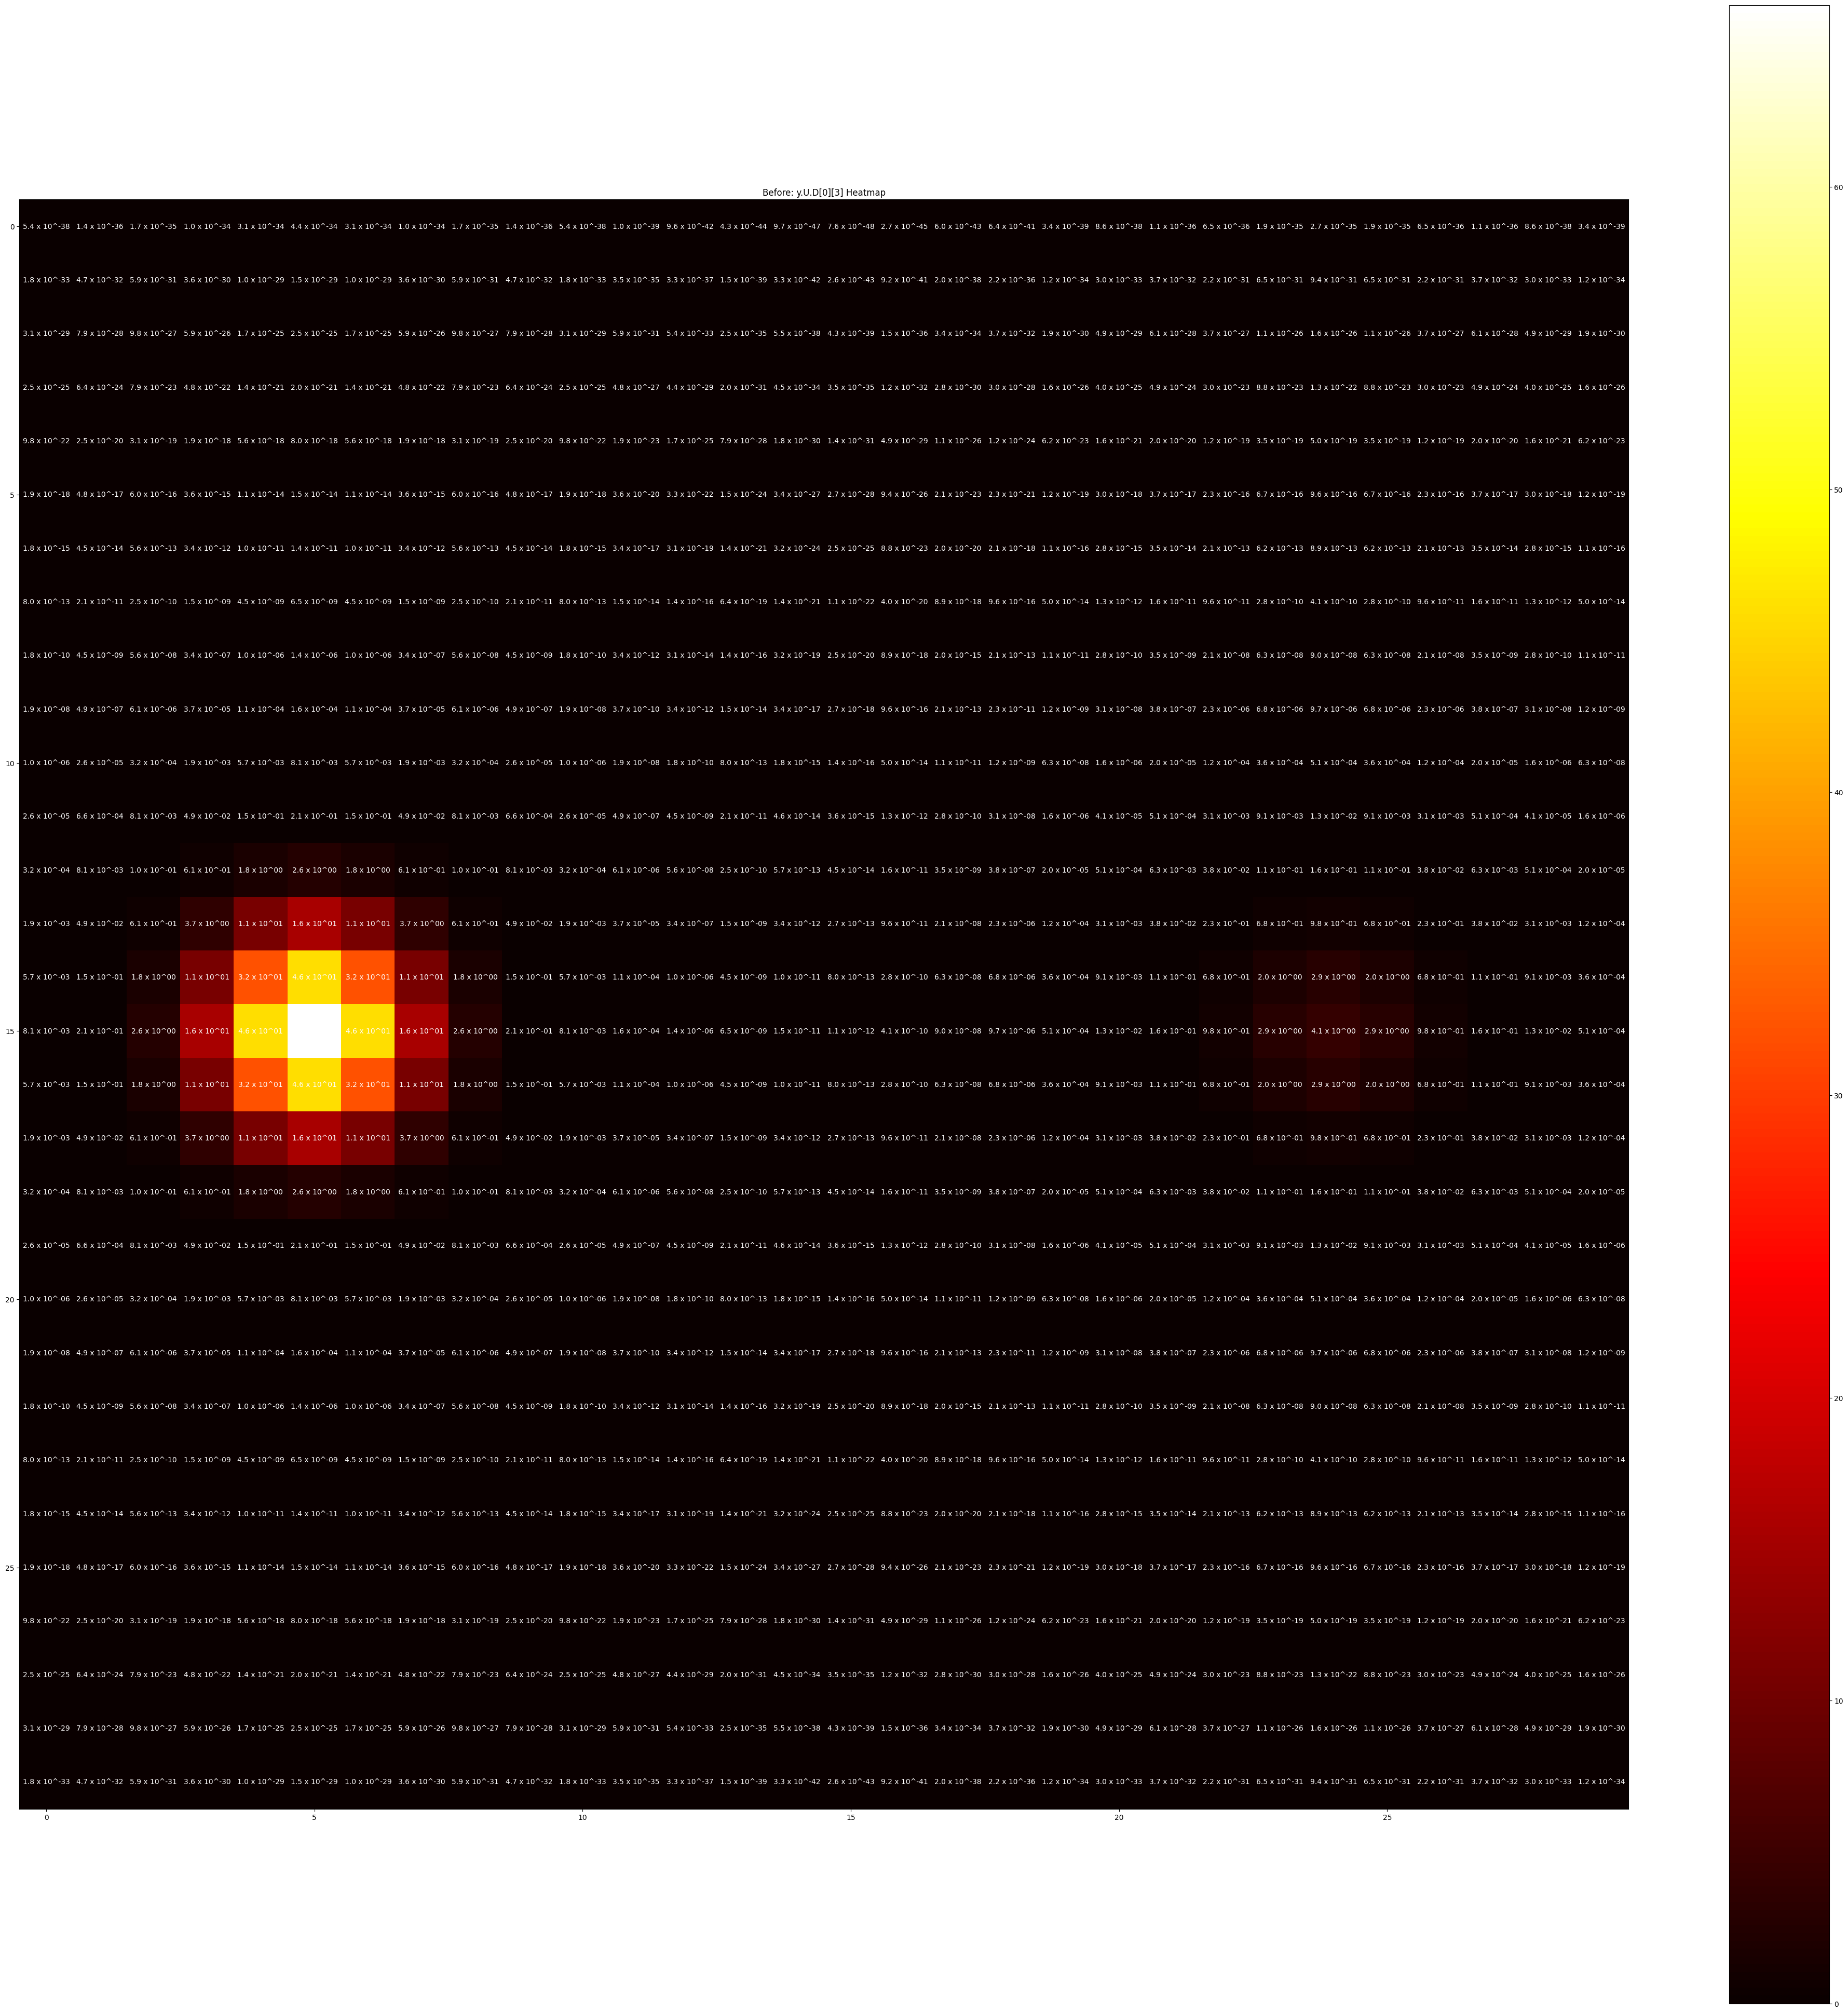

after


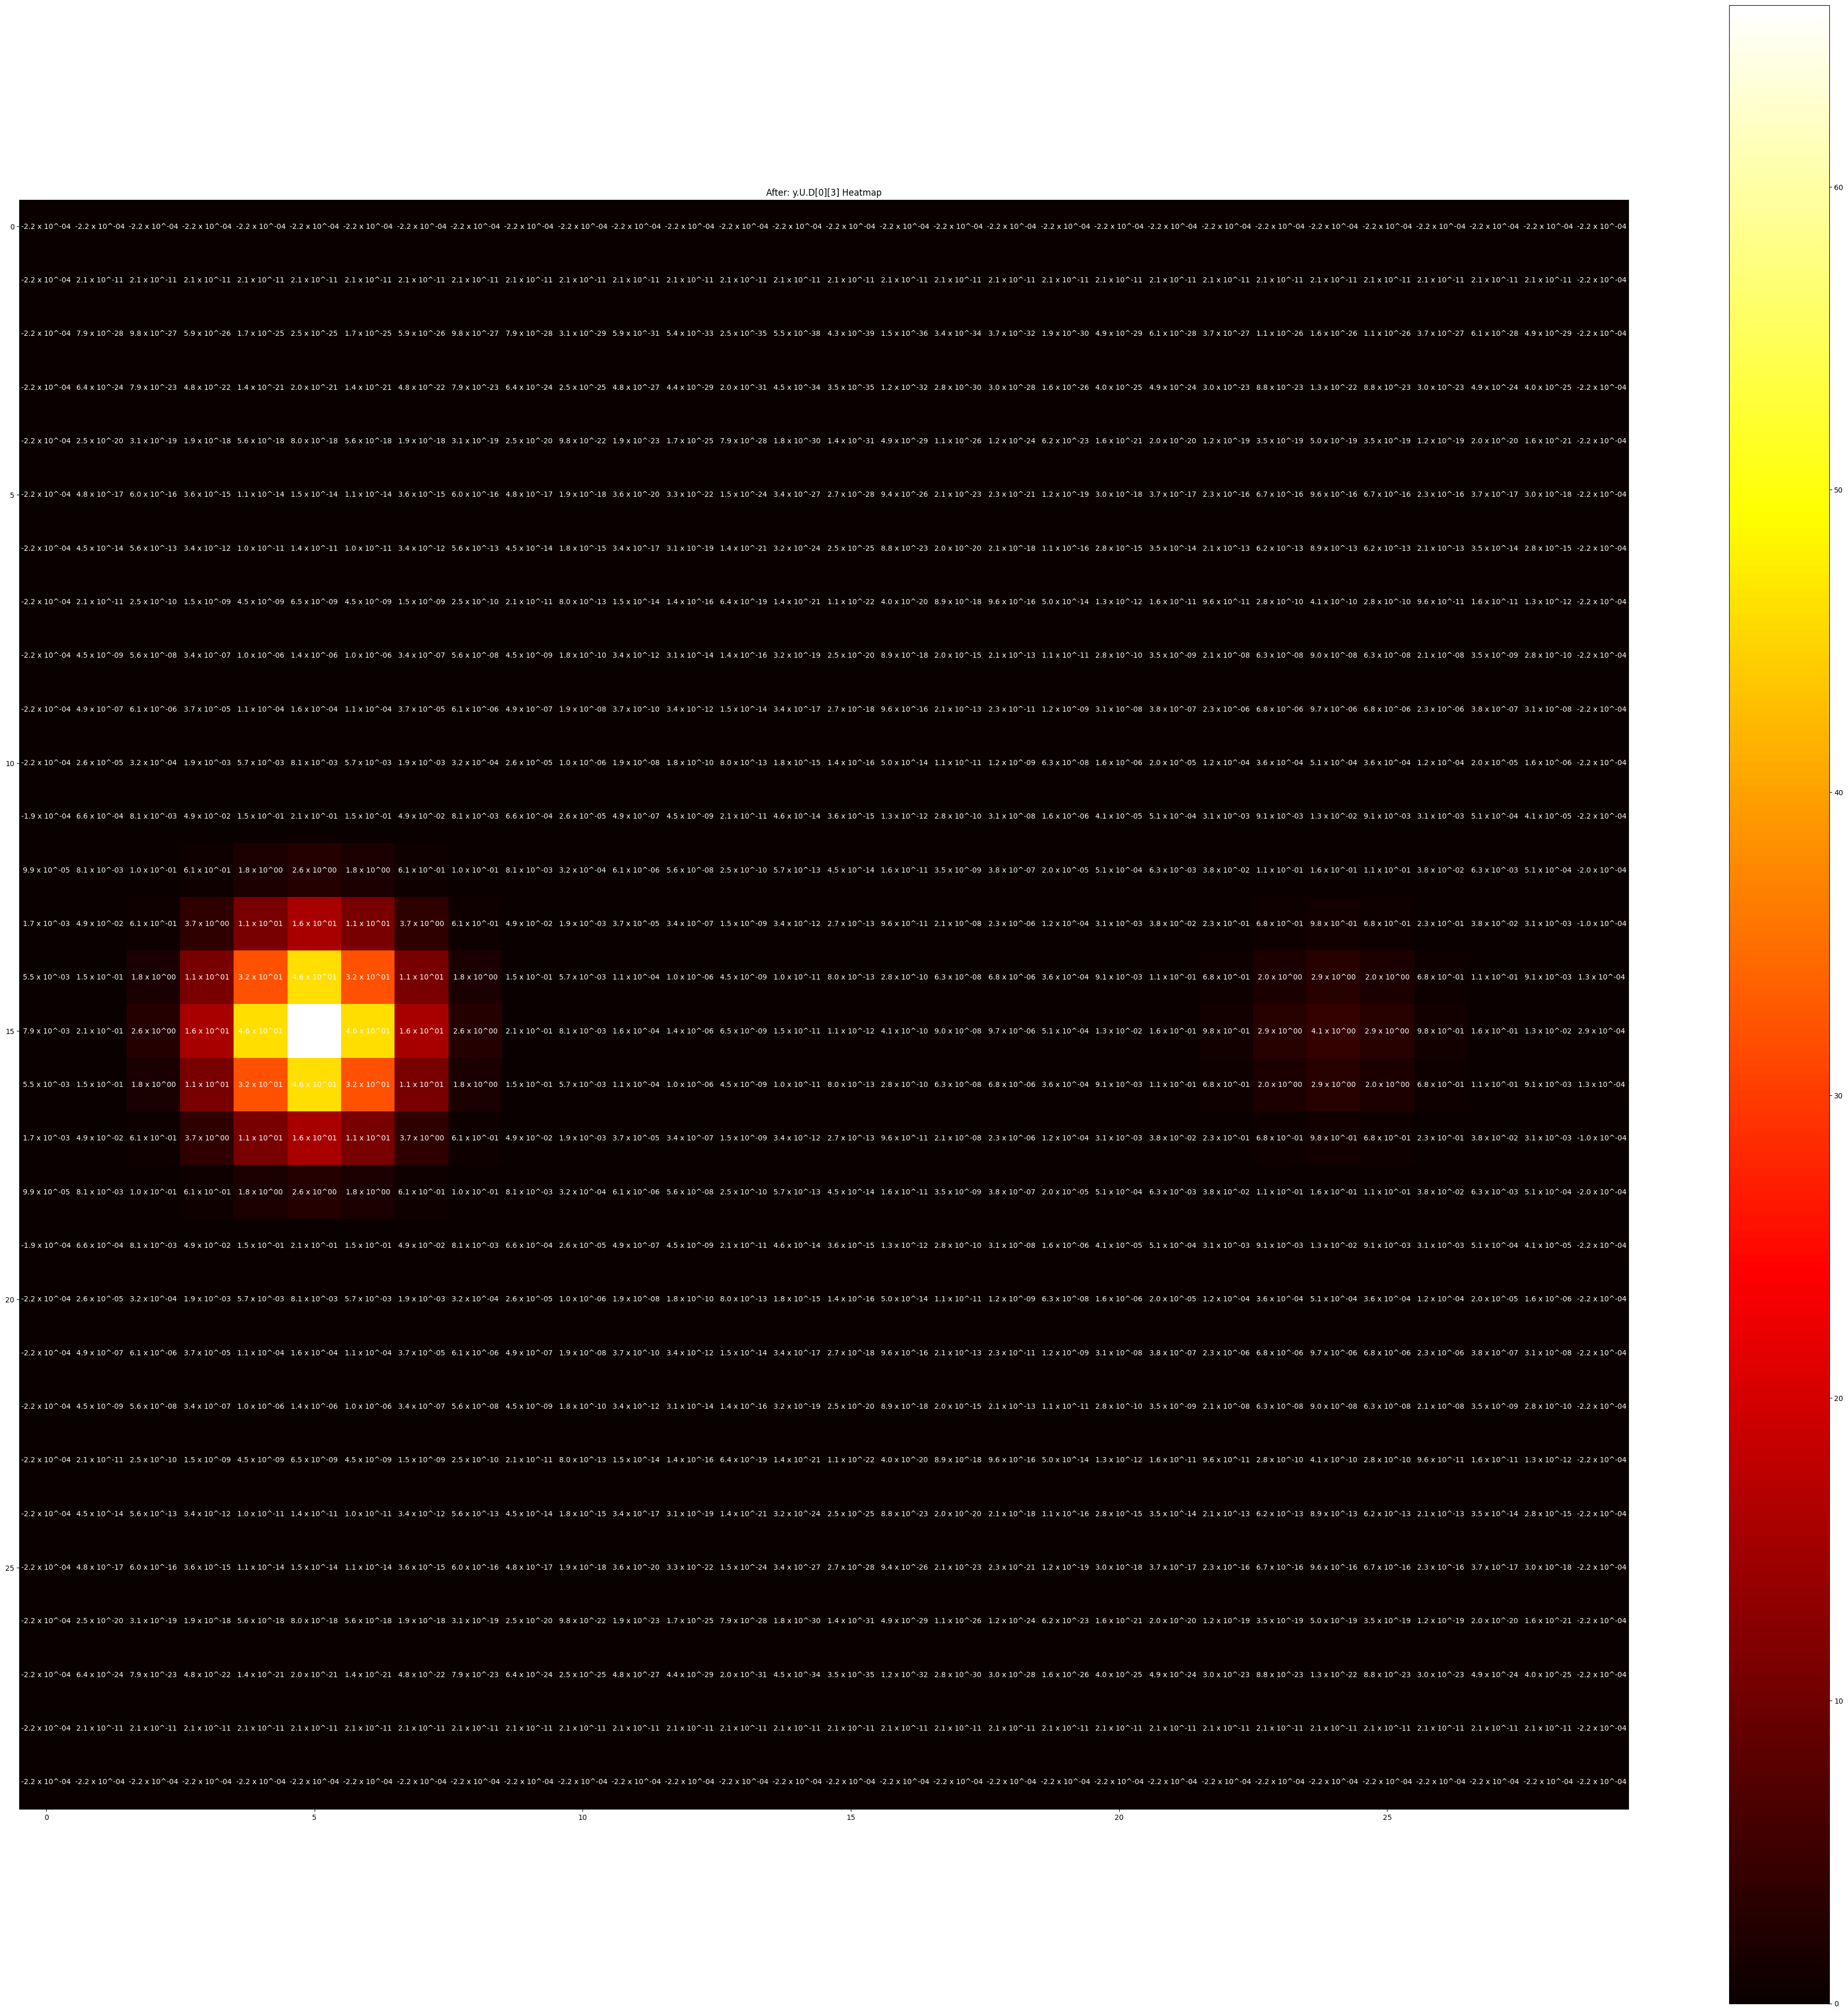

In [27]:
ll = (1.0, 1.0, 1.0)
w, x, y, z = [CSvar(rho_0, rho_1, T, ll, 'fisher-rao') for _ in range(4)]

Q = precomputeProjInterp(x.cs, rho_0, rho_1)
HQH = precomputeHQH(Q[0], H, x.cs, x.ll) if H is not None else None
# Adjust the time step here as needed
t = 3

print('before')
plt.figure(figsize=(50, 50))
im = plt.imshow(y.U.D[0][t], cmap='hot')
plt.colorbar(im)
plt.title(f'Before: y.U.D[0][{t}] Heatmap')
for i in range(y.U.D[0][t].shape[0]):
    for j in range(y.U.D[0][t].shape[1]):
        v = y.U.D[0][t][i, j]
        s = f"{v:.1e}"
        s = s.replace('e+', " x 10^").replace('e-', " x 10^-")
        plt.text(j, i, s, ha='center', va='center', color='white')
plt.show()

projinterp_constraint_(y, x, Q, HQH, H, F)

print('after')
plt.figure(figsize=(50, 50))
im = plt.imshow(y.U.D[0][t], cmap='hot')
plt.colorbar(im)
plt.title(f'After: y.U.D[0][{t}] Heatmap')
for i in range(y.U.D[0][t].shape[0]):
    for j in range(y.U.D[0][t].shape[1]):
        v = y.U.D[0][t][i, j]
        s = f"{v:.1e}"
        s = s.replace('e+', " x 10^").replace('e-', " x 10^-")
        plt.text(j, i, s, ha='center', va='center', color='white')
plt.show()

We observe that after the projection, the mass on the barrier will significantly increase. In this case, the order of the mass on the barrier increase from $10^{-34}$ to $10^{-4}$. 